In [1]:
import calendar

In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
fb = pd.read_csv('data/pseudo_facebook.tsv', sep= '\t')
fb.shape

(99003, 15)

In [4]:
fb.iloc[:3, :10]

,userid,age,dob_day,dob_year,dob_month,gender,tenure,friend_count,friendships_initiated,likes
0,2094382,14,19,1999,11,male,266.0,0,0,0
1,1192601,14,2,1999,11,female,6.0,0,0,0
2,2083884,14,16,1999,11,male,13.0,0,0,0


In [5]:
fb['dob_day'].value_counts().sort_index().head()

1    7900
2    3409
3    3291
4    3217
5    3545
Name: dob_day, dtype: int64

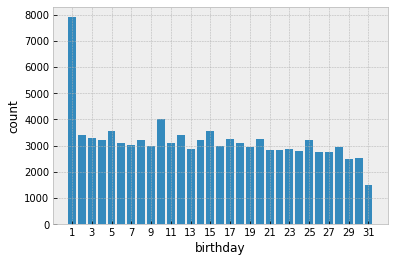

In [6]:
with plt.style.context('bmh'):
    plt.bar(range(1, 32), fb['dob_day'].value_counts().sort_index())
    plt.xticks(range(1, 31+1, 2))
    plt.xlabel('birthday')
    plt.ylabel('count')

We would expect the histogram to be somewhat uniform across the various days; however, the huge spike in the day 1 is somehow suspicious. And we know that not every month has 31 days, so the smaller count in that day is not that surprising.  

When you register at a websites, some sites have default setting that use the 1st day of the month under the birth day field. Some also use a default month of January. In the case of Facebook, Jan and the 1st are the first drop down items that appear on the site. It's important to think about such details and the data generating process when exploring data

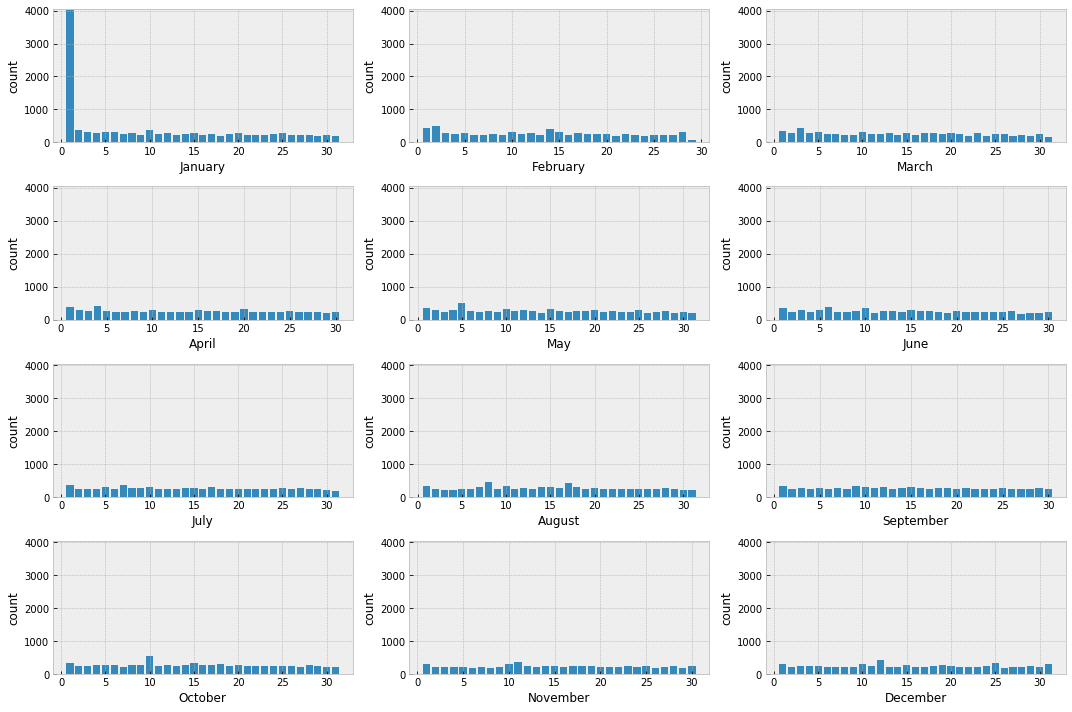

In [7]:
with plt.style.context('bmh'):
    n_rows = 4
    n_cols = 3
    f, ax = plt.subplots(nrows= n_rows, ncols= n_cols, figsize= (15, 10))

    k = 0
    for i in range(n_rows):
        for j in range(n_cols):
            a = ax[i][j]
            k += 1
            s = fb['dob_day'][fb['dob_month'] == k].value_counts().sort_index()
            a.bar(s.index, s.values)
            a.set_xlabel(calendar.month_name[k])
            a.set_ylabel('count')
            a.set_ylim(0, 4050) # first checked the values; 4032 is the value for Jan 01
    f.tight_layout()

In [8]:
fb.groupby(['dob_month', 'dob_day']).size().head()

dob_month  dob_day
1          1          4032
           2           365
           3           312
           4           278
           5           306
dtype: int64

In [9]:
df = fb.groupby(['dob_month', 'dob_day']).size()
df.name = 'vals'
df = df.reset_index()
df.head()

,dob_month,dob_day,vals
0,1,1,4032
1,1,2,365
2,1,3,312
3,1,4,278
4,1,5,306


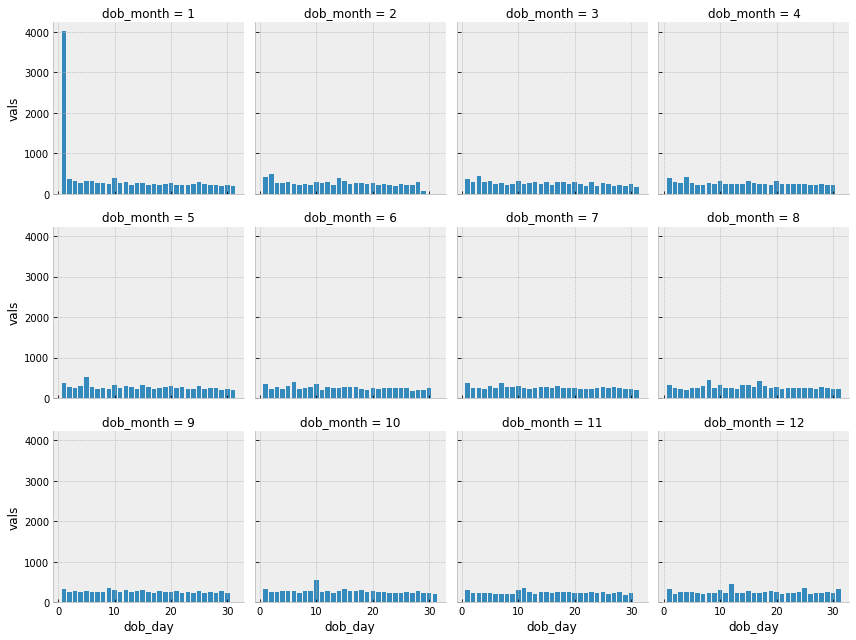

In [10]:
with plt.style.context('bmh'):
    g = sns.FacetGrid(df, col= 'dob_month', col_wrap= 4)
    g.map(plt.bar, 'dob_day', 'vals');

Being lazy, or trying to protect their privacy, it seems that many people simply go with the default values provided for birthday: Jan 01.

In [11]:
df.groupby('dob_month').apply(lambda r: (max(r['vals']), r['dob_day'][r['vals'] == max(r['vals'])]))

dob_month
1     (4032, [1])
2      (495, [2])
3      (441, [3])
4      (407, [4])
5      (508, [5])
6      (391, [6])
7      (372, [1])
8      (448, [8])
9      (342, [9])
10    (547, [10])
11    (365, [11])
12    (447, [12])
dtype: object

In [12]:
fb['friend_count'].describe()

count    99003.000000
mean       196.350787
std        387.304229
min          0.000000
25%         31.000000
50%         82.000000
75%        206.000000
max       4923.000000
Name: friend_count, dtype: float64

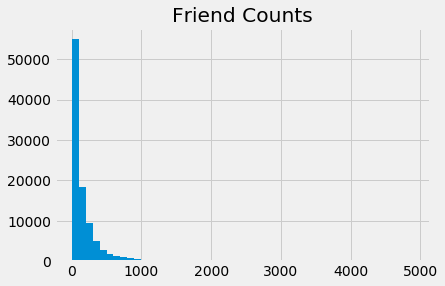

In [13]:
with plt.style.context('fivethirtyeight'):
    plt.hist(fb['friend_count'], bins= range(0, 5000, 100))
    plt.title('Friend Counts')

As you see, the data is __over-dispersed__. "Over-dispersed" is always relative to some particular posited distribution. For example, data might be over-dispersed compared with a Normal distribution with that mean.

In [14]:
stats.skew(fb['friend_count'])

6.058916683223884

In [15]:
np.percentile(fb['friend_count'], q= [0, 25, 50, 75, 90, 95, 99, 100])

array([    0.  ,    31.  ,    82.  ,   206.  ,   440.  ,   720.  ,
        1918.92,  4923.  ])

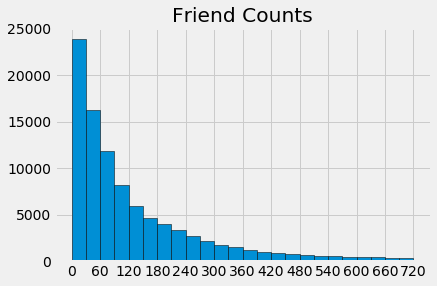

In [16]:
with plt.style.context('fivethirtyeight'):
    plt.hist(fb['friend_count'][fb['friend_count'] < 720], bins= range(0, 750, 30),
             edgecolor= 'black')
    plt.title('Friend Counts')
    plt.xticks(range(0, 750, 30 * 2))

In [17]:
stats.skew(np.log(fb['friend_count'] + 1))

-0.5052808516303124

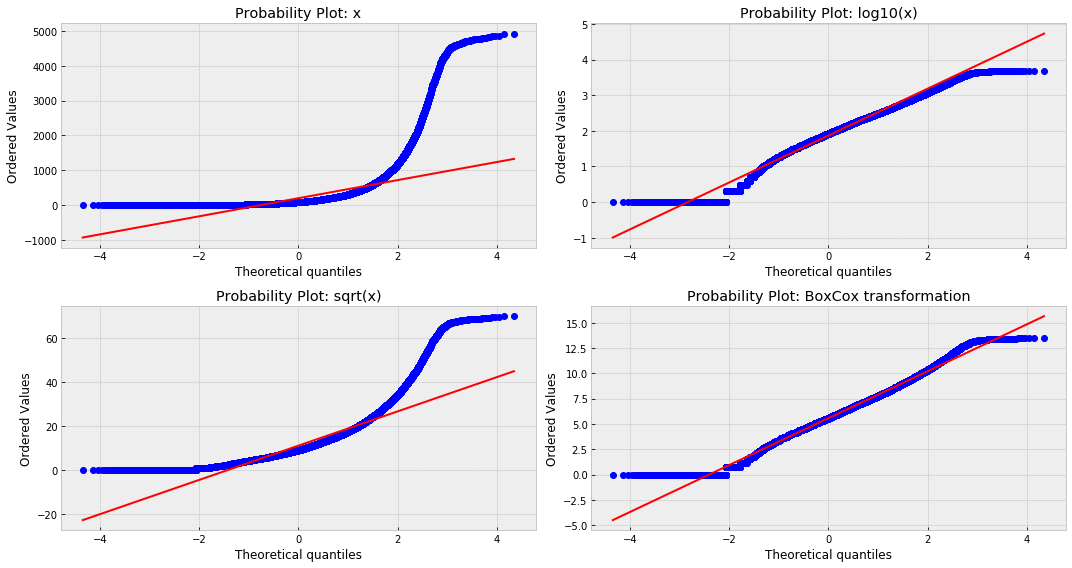

In [18]:
with plt.style.context('bmh'):
    fig = plt.figure(figsize= (15, 8))
    ax1 = fig.add_subplot(221)
    x = fb['friend_count']
    prob = stats.probplot(x, dist= stats.norm, plot= ax1)
    plt.title('Probability Plot: x')

    ax2 = fig.add_subplot(222)
    prob = stats.probplot(np.log10(x + 1), dist= stats.norm, plot= ax2)
    plt.title('Probability Plot: log10(x)')

    ax3 = fig.add_subplot(223)
    prob = stats.probplot(np.sqrt(x), dist= stats.norm, plot= ax3)
    plt.title('Probability Plot: sqrt(x)')

    ax4 = fig.add_subplot(224)
    xt, _ = stats.boxcox(x + 1)
    prob = stats.probplot(xt, dist= stats.norm, plot= ax4)
    plt.title('Probability Plot: BoxCox transformation')

    plt.tight_layout()

In [19]:
"""
For more info:
""";
# https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.boxcox.html

In [20]:
for v in [x, np.sqrt(x), np.log10(x+1), xt]:
    print(round(stats.skew(v), 4))

6.0589
2.1788
-0.5053
0.0099


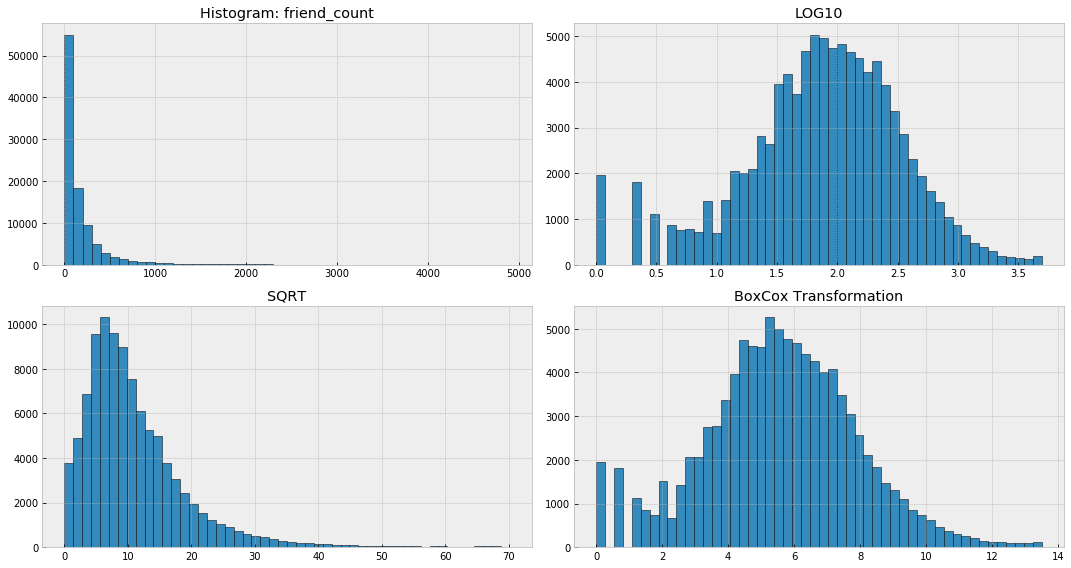

In [21]:
with plt.style.context('bmh'):
    fig = plt.figure(figsize= (15, 8))
    ax1 = fig.add_subplot(221)
    x = fb['friend_count']
    plt.hist(x, bins= range(0, 5000, 100), edgecolor= 'black')
    plt.title('Histogram: friend_count')

    ax2 = fig.add_subplot(222)
    plt.hist(np.log10(x + 1), bins= 50, edgecolor= 'black')
    plt.title('LOG10')
    

    ax3 = fig.add_subplot(223)
    plt.hist(np.sqrt(x), bins= 50, edgecolor= 'black')
    plt.title('SQRT')
    

    ax4 = fig.add_subplot(224)
    xt, _ = stats.boxcox(x + 1)
    plt.hist(xt, bins= 50, edgecolor= 'black')
    plt.title('BoxCox Transformation')
    

    plt.tight_layout()

In [22]:
"""
Which gender group, on average, has more friends?
"""
fb['gender'].value_counts(dropna= False) # 175 NaN values

male      58574
female    40254
NaN         175
Name: gender, dtype: int64

In [23]:
fb[['gender', 'friend_count']].groupby('gender').agg(['size', 'min', 'median', 'mean', 'max']).round()

friend_count                        
               size min median   mean   max
gender                                     
female        40254   0     96  242.0  4923
male          58574   0     74  165.0  4917

In [24]:
"""
To see which variables have missing values and how many:
"""
pd.isnull(fb).sum()

userid                     0
age                        0
dob_day                    0
dob_year                   0
dob_month                  0
gender                   175
tenure                     2
friend_count               0
friendships_initiated      0
likes                      0
likes_received             0
mobile_likes               0
mobile_likes_received      0
www_likes                  0
www_likes_received         0
dtype: int64

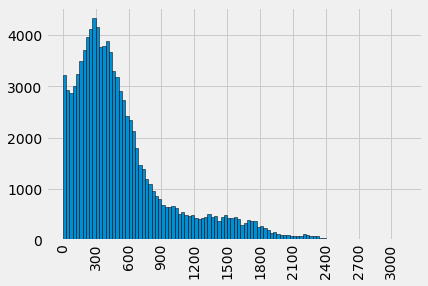

In [25]:
with plt.style.context('fivethirtyeight'):
    plt.hist(fb['tenure'][~ pd.isnull(fb['tenure'])], bins= range(0, 3150, 30),
             edgecolor= 'black');
    plt.xticks(range(0, 3150, 30 * 10), rotation= 90)

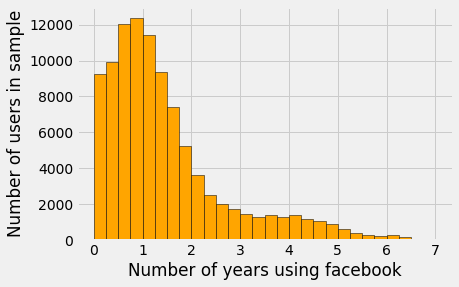

In [26]:
with plt.style.context('fivethirtyeight'):
    plt.hist(fb['tenure'][~ pd.isnull(fb['tenure'])] / 365, bins= np.linspace(0, 7, 29),
             edgecolor= 'black', facecolor= 'orange');
    plt.xticks(range(0, 8))
    plt.xlabel('Number of years using facebook')
    plt.ylabel('Number of users in sample')

In [27]:
fb[['gender', 'tenure']].groupby('gender').agg(['size', 'min', 'median', 'mean', 'max']).round()

tenure                           
         size  min median   mean     max
gender                                  
female  40254  0.0  438.0  587.0  3129.0
male    58574  0.0  393.0  500.0  3139.0

In [28]:
"""
50% of the users are bellow 28 years of age.
90% of the users are bellow 67 years of age.
"""
np.percentile(fb['age'], q= [0, 25, 50, 75, 90, 95, 99, 100])

array([  13.,   20.,   28.,   50.,   67.,   90.,  108.,  113.])

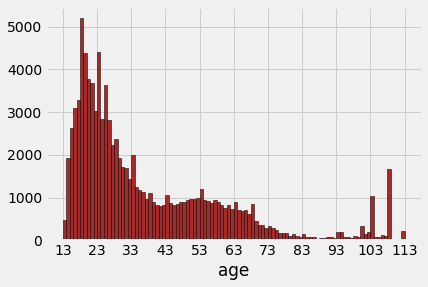

In [29]:
m, M = fb['age'].min(), fb['age'].max()

with plt.style.context('fivethirtyeight'):
    plt.hist(fb['age'], bins= range(m, M+1), edgecolor= 'black', facecolor= 'brown')
    plt.xticks(range(m, M+1, 10))
    plt.xlabel('age')

To set up a Facebook account, users must be at least 13 years old; as the summary statistics and the histogram suggest, most of the users are bellow 50; there are some suspicious users wit age of about 80.

In [30]:
fb['www_likes'].describe()

count    99003.000000
mean        49.962425
std        285.560152
min          0.000000
25%          0.000000
50%          0.000000
75%          7.000000
max      14865.000000
Name: www_likes, dtype: float64

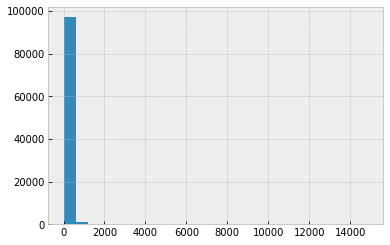

In [31]:
with plt.style.context('bmh'):
    plt.hist(fb['www_likes'], bins= 25)

In [32]:
stats.skew(fb['www_likes'])

16.91076906789301

In [33]:
fb[['gender', 'www_likes']].groupby('gender').describe().round().astype('int')

www_likes                                 
           count mean  std min 25% 50% 75%    max
gender                                           
female     40254   87  384   0   0   0  25  14865
male       58574   24  187   0   0   0   2  12903

In [34]:
df = fb[['gender', 'www_likes']].groupby('gender').agg(['min', 'median', 'mean'])
df.round().astype('int')

www_likes            
             min median mean
gender                      
female         0      0   87
male           0      0   24

In [35]:
fb['friendships_initiated'].describe()

count    99003.000000
mean       107.452471
std        188.786951
min          0.000000
25%         17.000000
50%         46.000000
75%        117.000000
max       4144.000000
Name: friendships_initiated, dtype: float64

In [36]:
fb[['friendships_initiated', 'gender']].groupby('gender').describe().round().astype('int')

friendships_initiated                                 
                       count mean  std min 25% 50%  75%   max
gender                                                       
female                 40254  114  195   0  19  49  125  3654
male                   58574  103  184   0  15  44  111  4144

In [37]:
fb['mobile_likes'].describe()

count    99003.000000
mean       106.116300
std        445.252985
min          0.000000
25%          0.000000
50%          4.000000
75%         46.000000
max      25111.000000
Name: mobile_likes, dtype: float64

In [38]:
stats.skew(fb['mobile_likes']) # highly skewed 

14.161021999266445

In [39]:
"""
Let's investigate if the users used the 'mobile_likes' feature at all:
"""
(fb['mobile_likes'] > 0).value_counts()

True     63947
False    35056
Name: mobile_likes, dtype: int64

In [40]:
"""
35.4% of the users in our dataset haven't used the 'mobile_likes' feature:
"""
(fb['mobile_likes'] > 0).value_counts(normalize= True).round(3) * 100

True     64.6
False    35.4
Name: mobile_likes, dtype: float64